In [26]:
import matplotlib.pyplot as plt 
import numpy as np
from tqdm import tqdm
import pandas as pd
import h5py

# Read mass accretion data

In [27]:
# snapshots and redshifts 
metadata_file = "../../data/processed/tng/tng300-1-table.csv"

snaps = np.arange(100)
metadata = pd.read_csv(metadata_file)
zs = metadata["Redshift"].values
scales = 1 / (1 + zs)
snaps.shape, zs.shape, scales.shape

((100,), (100,), (100,))

In [28]:
# read in trees, matches

with open("../../data/tng/tng100_trees.npz", 'rb') as f:
    npz_data = np.load(f)
    tbar = npz_data['tbar']
    tdmo = npz_data['tdmo']
    bbar = npz_data['bbar']
    bdmo = npz_data['bdmo']
    matches = npz_data['matches']

tbar.shape, tdmo.shape, bbar.shape, bdmo.shape, matches.shape

((4038, 100), (19049, 100), (4038,), (19049,), (4038,))

In [29]:
# apply cuts

# extract haloes and MAHs within given present-day mass range
# with no errors, exist in present day and matches with DMO 
mah_dmo = [] 
mah_bar = []
dmo_id = [] 
bar_id = []
dmo_is_sub = []
bar_is_sub = [] 

for ii in tqdm(range(len(tbar))):
    match = matches[ii]
    if match != -1: 
                
        ok_dmo = ~bdmo['is_err'][match]
        ok_bar = ~bbar['is_err'][ii]
        
        mvir_dmo = tdmo['mdm'][match]
        mvir_bar = tbar['mdm'][ii]
        assert mvir_dmo.shape == (100,)
        dmo_mah = np.log10(mvir_dmo, out=np.zeros_like(mvir_dmo), where=(mvir_dmo!=0))
        bar_mah = np.log10(mvir_bar, out=np.zeros_like(mvir_bar), where=(mvir_bar!=0))

        # extract id (present)
        dmo_subfind_id = tdmo['subfind_id'][match, -1]
        bar_subfind_id = tbar['subfind_id'][ii, -1]

        # extract whether halo is central or not (present)
        dmo_is_sub_ii = tdmo['is_sub'][match, -1]
        bar_is_sub_ii = tbar['is_sub'][ii, -1]

        
        # should also check if halo exists in present day
        mpeak_pre_dmo = np.log10(bdmo['mpeak_pre'][match])
        mpeak_pre_bar = np.log10(bbar['mpeak_pre'][ii])
        
        is_cut_dmo = (mpeak_pre_dmo > 11.5) & ( mpeak_pre_dmo < 12) & (tdmo['mvir'][match,-1] > 0)
        is_cut_bar = (mpeak_pre_bar > 11.5) & ( mpeak_pre_bar < 12) & (tbar['mvir'][ii,-1] > 0)
        
        if ok_dmo & is_cut_dmo & ok_bar & is_cut_bar:
            mah_dmo.append(dmo_mah)
            mah_bar.append(bar_mah)
            dmo_id.append(dmo_subfind_id)
            bar_id.append(bar_subfind_id)
            dmo_is_sub.append(dmo_is_sub_ii)
            bar_is_sub.append(bar_is_sub_ii)



100%|██████████| 4038/4038 [00:00<00:00, 61091.79it/s]


In [30]:
# stack them into arrays
mah_dmo = np.concatenate([m.reshape(1, 100) for m in mah_dmo], axis=0)
mah_bar = np.concatenate([m.reshape(1, 100) for m in mah_bar], axis=0)
dmo_id = np.array(dmo_id)
bar_id = np.array(bar_id)
dmo_is_sub = np.array(dmo_is_sub)
bar_is_sub = np.array(bar_is_sub)

mah_dmo.shape, mah_bar.shape, dmo_id.shape, bar_id.shape, bar_is_sub.shape

((1642, 100), (1642, 100), (1642,), (1642,), (1642,))

In [31]:
# make sure they are sorted according to ids (easier to do additional matching later)
sorted_mask = np.argsort(bar_id)
bar_id = bar_id[sorted_mask]
dmo_id = dmo_id[sorted_mask]
mah_dmo = mah_dmo[sorted_mask]
mah_bar = mah_bar[sorted_mask]
dmo_is_sub = dmo_is_sub[sorted_mask]
bar_is_sub = bar_is_sub[sorted_mask]
assert np.all(sorted(bar_id) == bar_id)

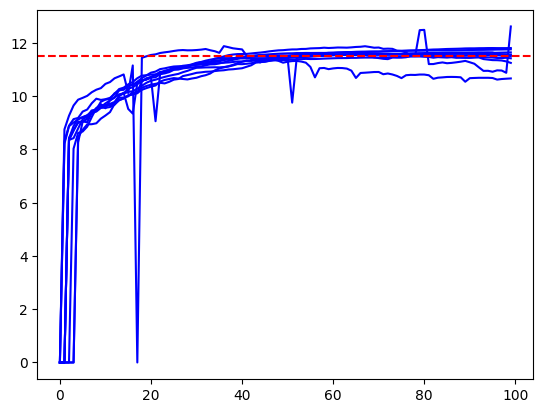

In [32]:
# random trees
indices = np.random.choice(len(mah_bar), size=10)
for idx in indices:
    plt.plot(mah_bar[idx], color='b')
plt.axhline(11.5, linestyle='--', color='r')

# Get trees in correct format

In [33]:
# interpolate to avoid missing snaps
from numpy import interp
mah_bar_interp = []
for ii in range(mah_bar.shape[0]):
    mah_ii = mah_bar[ii]
    is_zero = mah_ii == 0
    interp_ii = interp(scales, scales[~is_zero], mah_ii[~is_zero])
    mah_bar_interp.append(interp_ii.reshape(1, -1))

mah_bar_interp = np.concatenate(mah_bar_interp, axis=0)

In [34]:
# dmo too
from numpy import interp
mah_dmo_interp = []
for ii in range(mah_dmo.shape[0]):
    mah_ii = mah_dmo[ii]
    is_zero = mah_ii == 0
    interp_ii = interp(scales, scales[~is_zero], mah_ii[~is_zero])
    mah_dmo_interp.append(interp_ii.reshape(1, -1))

mah_dmo_interp = np.concatenate(mah_dmo_interp, axis=0)

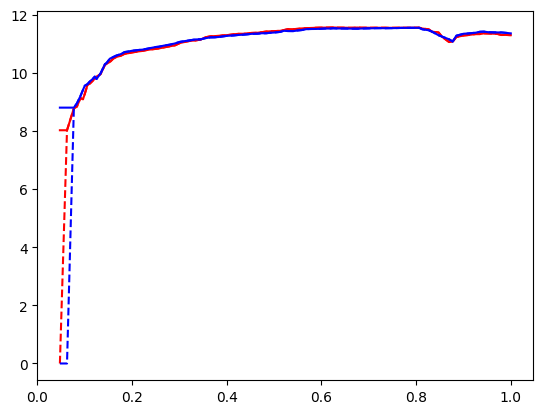

In [35]:
# it works
plt.plot(scales, mah_bar[17], linestyle='--', color='r')
plt.plot(scales, mah_bar_interp[17], color='r')
plt.plot(scales, mah_dmo[17], color='b', linestyle='--')
plt.plot(scales, mah_dmo_interp[17], color='b')


In [36]:
#  now we get mpeak from these trees
from multicam.tng.utils import get_mpeak_from_mah
mpeak_bar = get_mpeak_from_mah(mah_bar_interp)
mpeak_dmo = get_mpeak_from_mah(mah_dmo_interp)

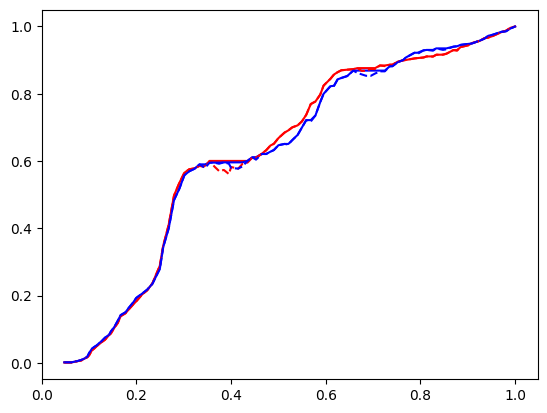

In [40]:
# looks like mpeak worked
idx = np.random.choice(range(mpeak_bar.shape[0]))
plt.plot(scales, mpeak_bar[idx], linestyle='-', color='r')
plt.plot(scales, mpeak_dmo[idx], linestyle='-', color='b')

plt.plot(scales, 10**mah_bar_interp[idx]/10**(np.max(mah_bar_interp[idx])), color='r', linestyle='--')
plt.plot(scales, 10**mah_dmo_interp[idx]/10**(np.max(mah_dmo_interp[idx])), color='b', linestyle='--')


# Read in masses (including stellar) from TNG files

In [41]:
from multicam.tng.utils import convert_tng_mass

# get gmass over all files 
dm_subhalo_ids = []
dm_subhalo_mass = []
dm_subhalo_pos = []
# dm_central_ids = []

count = 0

for ii in tqdm(range(0, 63)):
    filename = f'../../data/tng/100-dark/fof_subhalo_tab_099.{ii}.hdf5'
    with h5py.File(filename, 'r') as f:
        if 'SubhaloMass' in f['Subhalo'].keys():
            for s in f['Subhalo']['SubhaloMass']:
                dm_subhalo_ids.append(count)
                dm_subhalo_mass.append(s)
                count+=1


            for pos in f['Subhalo']['SubhaloPos']:
                dm_subhalo_pos.append(pos)

            # if 'GroupFirstSub' in f['Group']:
            #     for central_id in f['Group']['GroupFirstSub']:
            #         dm_central_ids.append(central_id)


dm_subhalo_ids = np.array(dm_subhalo_ids)
dm_subhalo_pos = np.array(dm_subhalo_pos)
dm_subhalo_mass = convert_tng_mass(np.array(dm_subhalo_mass))
# dm_central_ids = np.array(dm_central_ids)

dm_subhalo_ids.shape, dm_subhalo_mass.shape, dm_subhalo_pos.shape, 
# dm_central_ids.shape

  0%|          | 0/63 [00:00<?, ?it/s]

100%|██████████| 63/63 [00:11<00:00,  5.34it/s]


((4893237,), (4893237,), (4893237, 3))

In [42]:
from multicam.tng.utils import convert_tng_mass

# get gmass over all files 
subhalo_ids = []
subhalo_mass = []
stellar_mass = []
subhalo_pos = []
central_ids = []

count = 0

# TODO: add  SubhaloFlag 
for ii in tqdm(range(0, 448)):
    filename = f'../../data/tng/100/fof_subhalo_tab_099.{ii}.hdf5'
    with h5py.File(filename, 'r') as f:
        if 'SubhaloMass' in f['Subhalo'].keys():
            for s in f['Subhalo']['SubhaloMass']:
                subhalo_ids.append(count)
                subhalo_mass.append(s)
                count+=1

            for s in f['Subhalo']['SubhaloMassInRadType'][:,4]: # 4 = star particles
                stellar_mass.append(s)

            for pos in f['Subhalo']['SubhaloPos']:
                subhalo_pos.append(pos)


            # if 'GroupFirstSub' in f['Group']:
            #     for central_id in f['Group']['GroupFirstSub']:
            #         central_ids.append(central_id)

subhalo_ids = np.array(subhalo_ids)
subhalo_pos = np.array(subhalo_pos)
central_ids = np.array(central_ids)
subhalo_mass = convert_tng_mass(np.array(subhalo_mass))
stellar_mass = convert_tng_mass(np.array(stellar_mass))

subhalo_ids.shape, subhalo_mass.shape, stellar_mass.shape, subhalo_pos.shape, 
# central_ids.shape

100%|██████████| 448/448 [00:11<00:00, 38.03it/s] 
/Users/imendoza/code/nbody-relaxed/multicam/tng/utils.py:24: RuntimeWarning: divide by zero encountered in log10
  return np.where(gmass > 0, np.log10(gmass * 1e10 / TNG_H), 0)


((4371211,), (4371211,), (4371211,), (4371211, 3))

In [43]:
# filename = f'../../data/tng/100-dark/fof_subhalo_tab_099.0.hdf5'
# with h5py.File(filename, 'r') as f:
#     print(f['Group'].keys())
#     print(f['Group']['GroupFirstSub'].shape)
#     print(f['Group']['GroupFirstSub'][:])
#     print(f.keys())
#     print(f['Subhalo'].keys())

In [44]:
# match and compare masses (baryon)
assert np.all(sorted(subhalo_ids) == subhalo_ids)
match1 = np.isin(subhalo_ids, bar_id)

subhalo_mass_matched = subhalo_mass[match1]
stellar_mass_matched = stellar_mass[match1]
subhalo_pos_matched = subhalo_pos[match1] / 1e3 #ckpc/h -> cMpc/h, comoving
match1.shape, subhalo_mass_matched.shape, subhalo_pos_matched.shape

((4371211,), (1642,), (1642, 3))

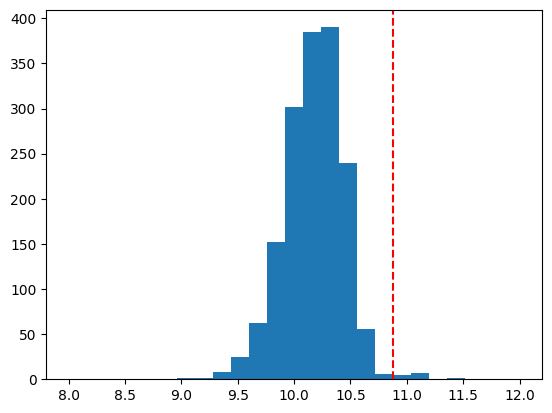

In [55]:
from multicam.tng.utils import TNG_H
plt.hist(stellar_mass_matched, bins=25, range=(8, 12))
plt.axvline(np.log10(5.1 * 1e10 / TNG_H), c='r', linestyle='--') # boryana's cut (2020)

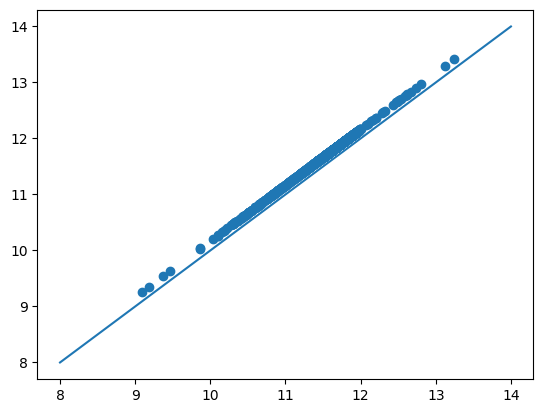

In [46]:
# should be the same!
plt.plot([8, 14], [8, 14])
plt.scatter(mah_bar[:, -1], subhalo_mass_matched)
# small displacement due to that weird group conversation factor that doesn't matter


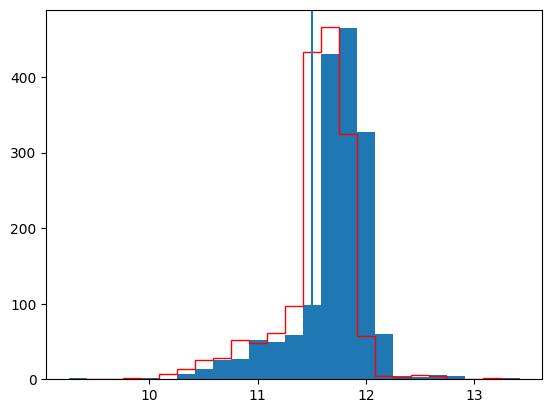

In [47]:
_, bins, _ = plt.hist(subhalo_mass_matched, bins=25)
plt.hist(mah_bar[:, -1], bins=bins, color='r', histtype='step')
plt.axvline(11.5)

In [48]:
# still significant number of haloes below threshold in present day mass
sum(mah_bar[:, -1] < 11.5)

409

In [49]:
# factor
mah_bar[13, -1], subhalo_mass_matched[13] # ~0.2 displacement, but 11.5 cut in mah_bar is more strict

(11.241158, 11.410313)

# Read in colors

In [32]:
from multicam.tng.utils import get_color_and_match
color_file = "../../data/tng/Subhalo_StellarPhot_p07c_cf00dust_res_conv_ns1_rad30pkpc_099.hdf5"
colors = get_color_and_match(color_file, bar_id)
gr = colors['sdss_g'] - colors['sdss_r']

(array([  2.,   1.,   5.,  14.,  18.,  58.,  77., 111., 152., 167., 155.,
        118.,  94.,  79.,  50.,  47.,  29.,  36.,  42.,  53., 116., 153.,
         55.,   8.,   2.]),
 array([0.1636734 , 0.19245109, 0.22122879, 0.2500065 , 0.27878419,
        0.30756187, 0.33633956, 0.36511725, 0.39389497, 0.42267266,
        0.45145035, 0.48022804, 0.50900573, 0.53778344, 0.5665611 ,
        0.59533882, 0.62411654, 0.6528942 , 0.68167192, 0.71044958,
        0.73922729, 0.76800501, 0.79678267, 0.82556039, 0.85433805,
        0.88311577]),
 <BarContainer object of 25 artists>)

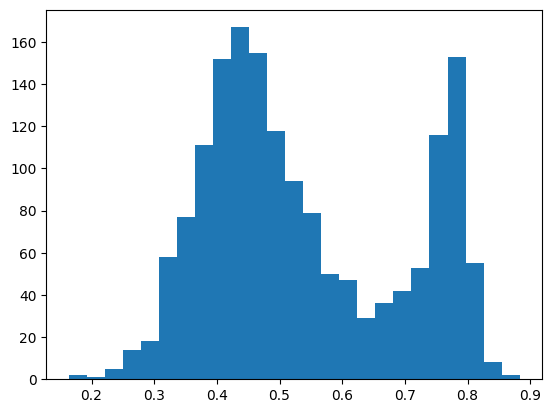

In [33]:
plt.hist(gr, bins=25)

# Color correlations with MAH

/Users/imendoza/code/nbody-relaxed/multicam/correlations.py:7: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return stats.spearmanr(*args, **kwargs).correlation


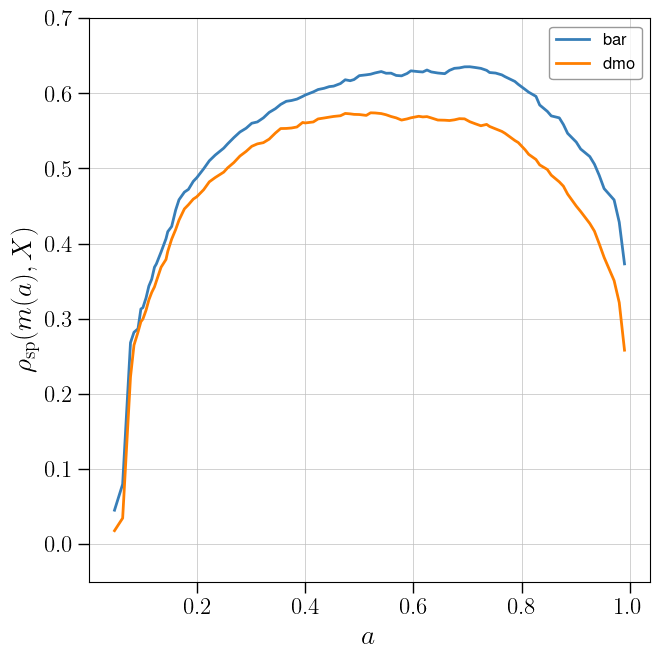

In [232]:

from multicam.correlations import spearmanr
from multicam.plotting import LATEX_PARAMS_TNG, set_rc
set_rc()


colors =['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 
         'C6'
         ]


fig, ax = plt.subplots(1, 1, figsize=(7, 7))

for ii, mpeak in enumerate([mpeak_bar, mpeak_dmo]):
    color= colors[ii]
    corrs = []
    for jj in range(mpeak_bar.shape[1]):
        corrs.append(spearmanr(gr, mpeak[:, jj]))


    corrs = np.array(corrs)
    scales_neg = scales[corrs < 0]
    scales_pos = scales[corrs > 0]
    corrs_neg = abs(corrs[corrs < 0])
    corrs_pos = abs(corrs[corrs > 0])

    label = LATEX_PARAMS_TNG['g-r']
    if len(scales_pos) > 0:
        ax.plot(scales_pos, corrs_pos, label='bar' if ii==0 else 'dmo', ls='-', color=color)
        label = None
    if len(scales_neg) > 0:
        ax.plot(scales_neg, corrs_neg, label='bar' if ii==0 else 'dmo', ls='--', color=color)



ax.legend(prop={'size': 12})
ax.set_ylabel(r'$\rho_{\rm sp}(m(a), X)$')

ax.set_xlabel(r'$a$')
ax.set_ylim(-0.05, 0.7)


plt.tight_layout()



# output and save final catalog to use

In [48]:
mah_dmo.shape

(1642, 100)

In [ ]:
dmo_cat ={
    'mvir': mah_dmo[:,-1], 
    'mpeak_mah': mpeak_dmo, 

 
 }

bar_cat ={
    'mvir': mah_bar[:, -1],
    'mpeak_mah': mpeak_bar, 
    'stear_mass': stellar_mass_matched,
}